In this file, I evaluate a dataset on garment employee productivity, found [here](https://archive.ics.uci.edu/dataset/597/productivity+prediction+of+garment+employees). In this instance, because we are going to want to predict 'high' productivity, defined as productivity level above the median, I am going to want a model that optimizes both recall and precision. In this instance, specifcity is not as important.

In [37]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from pract2_modules import plotColumnCounts
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, precision_recall_curve, roc_curve

In [2]:
df_all = pd.read_csv('garments_worker_productivity.csv')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [3]:
pd.DataFrame({'raw_missing': df_all.isna().sum(), 'prop_missing': df_all.isna().sum()/df_all.shape[0]})

,raw_missing,prop_missing
date,0,0.000000
quarter,0,0.000000
department,0,0.000000
day,0,0.000000
team,0,0.000000
targeted_productivity,0,0.000000
smv,0,0.000000
wip,506,0.422723
over_time,0,0.000000
incentive,0,0.000000


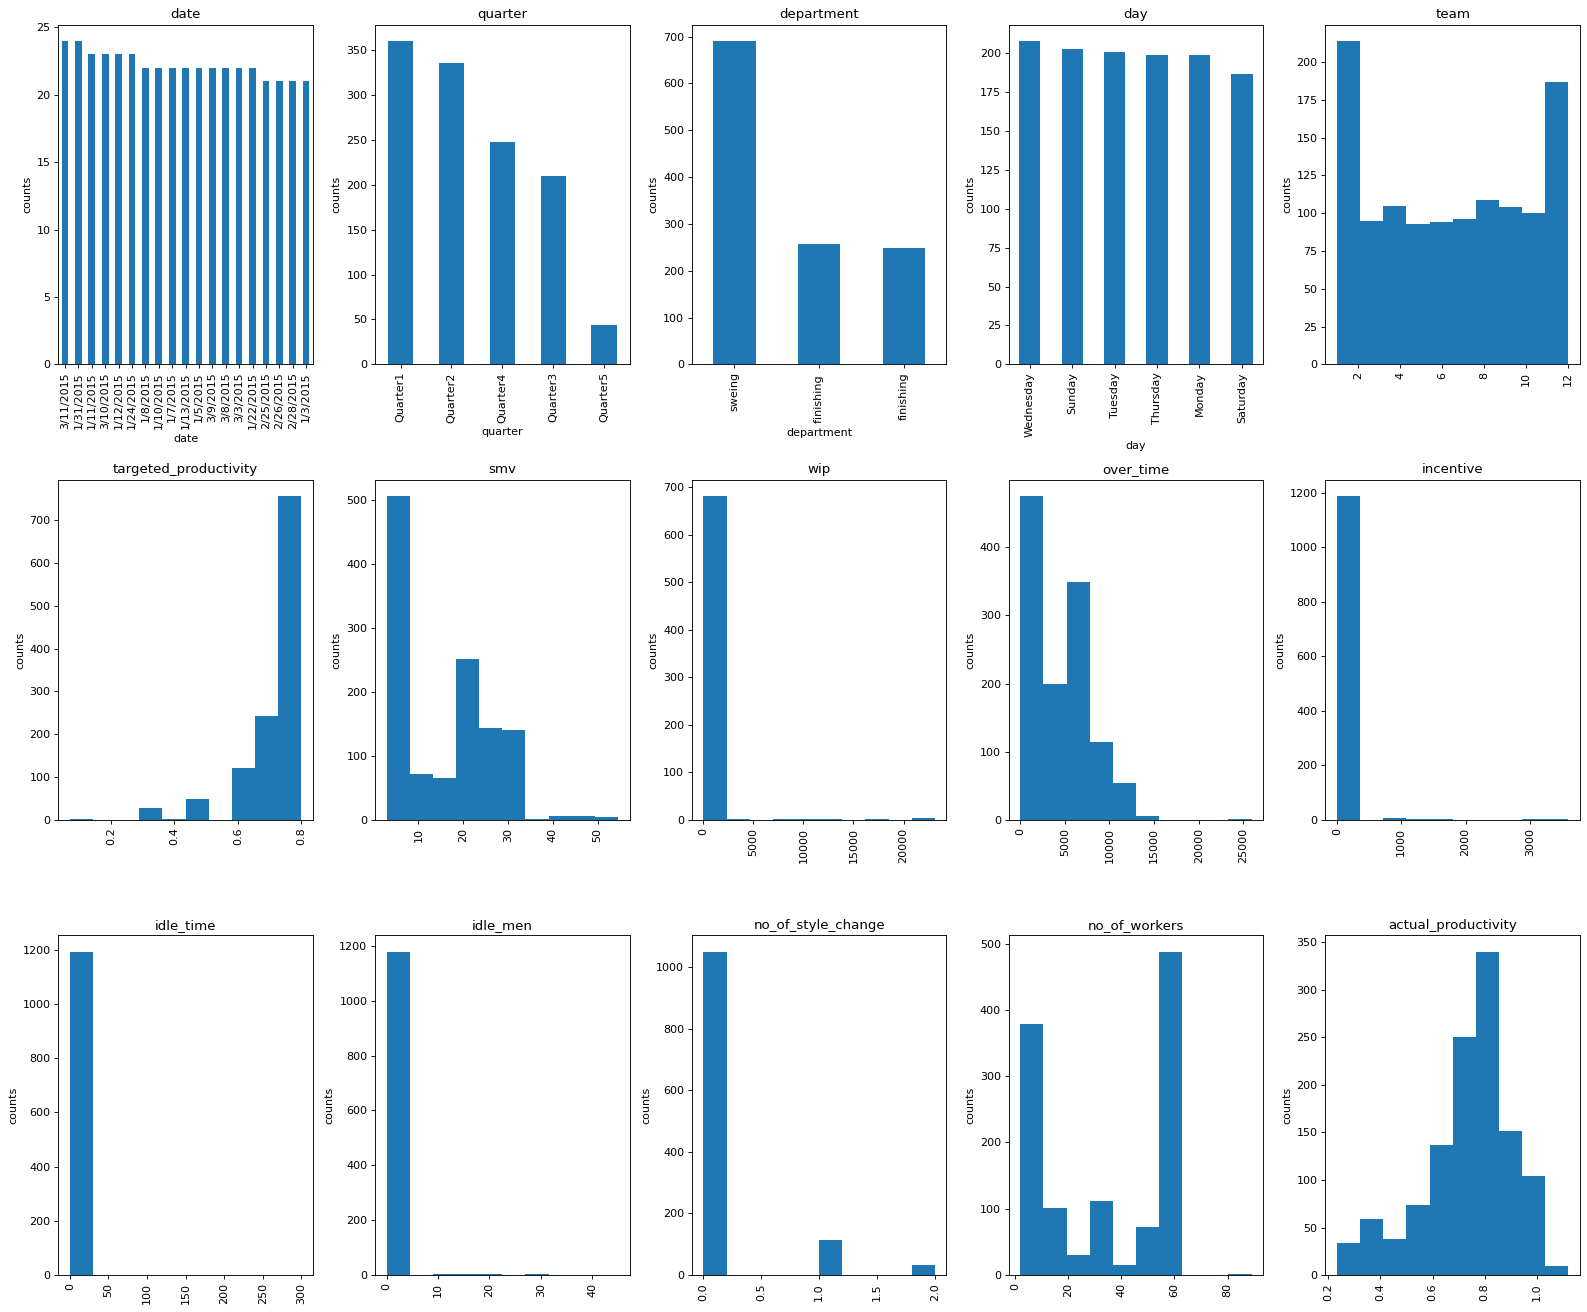

In [4]:
# plot columns
plotColumnCounts(df_all, df_all.columns, 5)

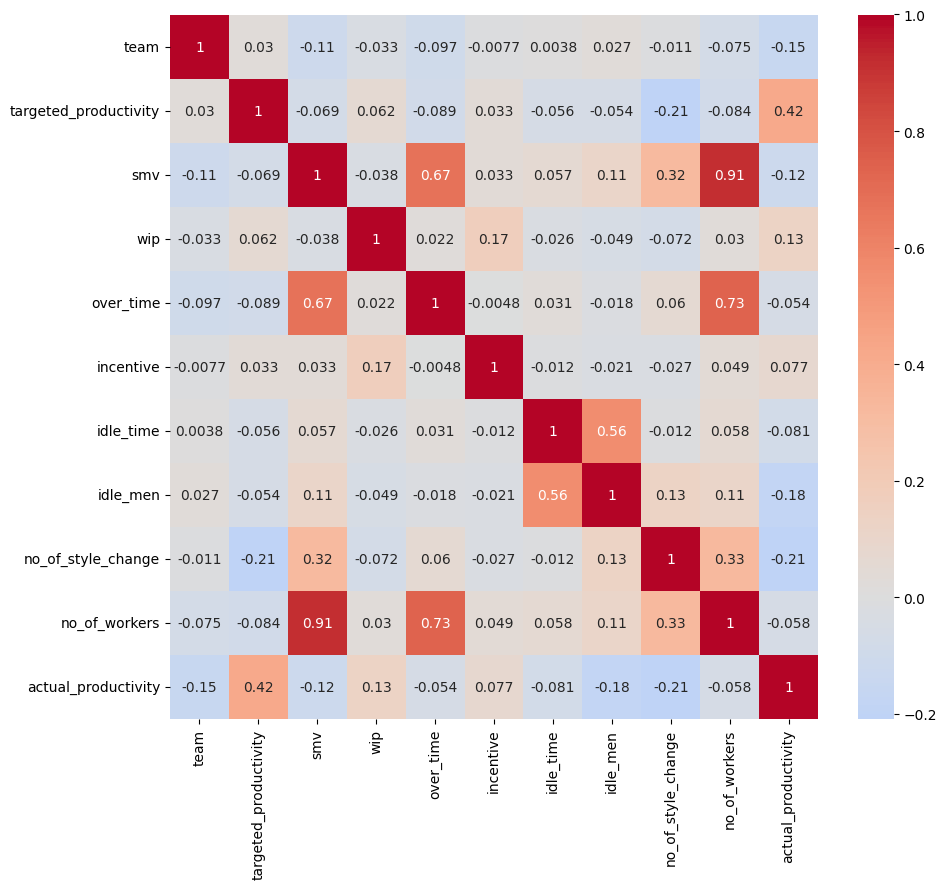

In [5]:
# missing 506 cases from WIP, which is almost 50%. wip stands for 'work in progress' an dincludes number of unifnished items for products; may be highly predictive
plt.figure(figsize=(10, 9))
sns.heatmap(df_all.select_dtypes(include='number').corr(), center = 0, annot = True, cmap = 'coolwarm')
plt.tight_layout()

`wip` doesn't have a strong correlation; it may improve model but take it out now for sake of ease. Will use KNNImputer in future work.

Investigate all object columns, `team`, and polychotomize `actual_productivity`.

## Investigate object cols

In [6]:
df_all.select_dtypes(include='object').columns

Index(['date', 'quarter', 'department', 'day'], dtype='object')

In [7]:
# drop date and day; these will be represented somewhat by quarter, which will be OrdinalEncoded

In [8]:
df_all['quarter'].value_counts()

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64

In [9]:
quarter_levels = ['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5']
print(quarter_levels)
all(x in quarter_levels for x in df_all.quarter.value_counts().index.tolist())#all(df_all.quarter.value_counts()[1:].tolist() in quarter_levels)

['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5']


True

In [10]:
# Fix departments
df_all['department'].value_counts()

department
sweing        691
finishing     257
finishing     249
Name: count, dtype: int64

In [11]:
df_all['department'] = ['Sewing' if x else 'Finishing' for x in df_all['department'] == 'sweing']
df_all['department'].value_counts()

department
Sewing       691
Finishing    506
Name: count, dtype: int64

## Investigate `team` and polychotomize `actual_productivity`

In [12]:
df_all.team.value_counts()

team
8     109
2     109
1     105
4     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: count, dtype: int64

In [13]:
df_all['team'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1197 entries, 0 to 1196
Series name: team
Non-Null Count  Dtype
--------------  -----
1197 non-null   int64
dtypes: int64(1)
memory usage: 9.5 KB


In [14]:
# Team is coded numerically but should be type object. Transform to object and use TargetEncoder for team
df_all['team'] = df_all['team'].astype('str').copy()
df_all.dtypes

date                      object
quarter                   object
department                object
day                       object
team                      object
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object

# Remove outliers & alter numeric features as needed

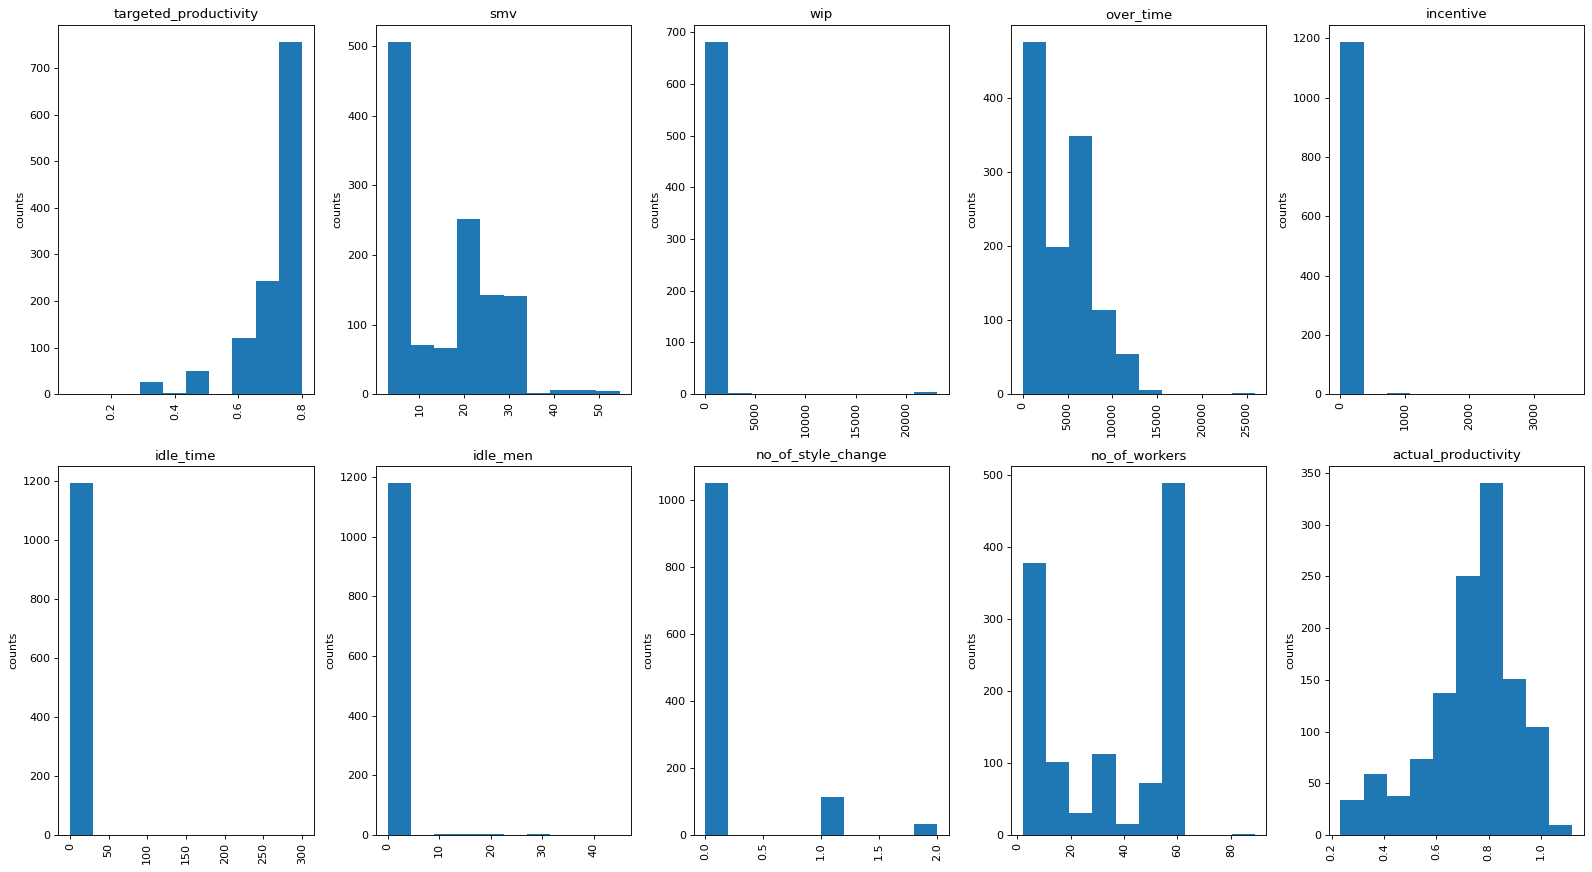

In [15]:
plotColumnCounts(df_all, df_all.select_dtypes('number').columns, 5)

`wip` will be removed. 

Remove outliers for `incentive`, `idle_time`, `idle_men`
sqrt transform `smv`, `over_time`

Investigate numeric columns for outliers

C:\Users\matth\AppData\Local\Temp\ipykernel_23636\3265817404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['incentive_trunc'] = trunc_sd(df_all, 'incentive', 3)
C:\Users\matth\AppData\Local\Temp\ipykernel_23636\3265817404.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['idle_time_trunc'] = trunc_sd(df_all, 'idle_time', 3)
C:\Users\matth\AppData\Local\Temp\ipykernel_23636\3265817404.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

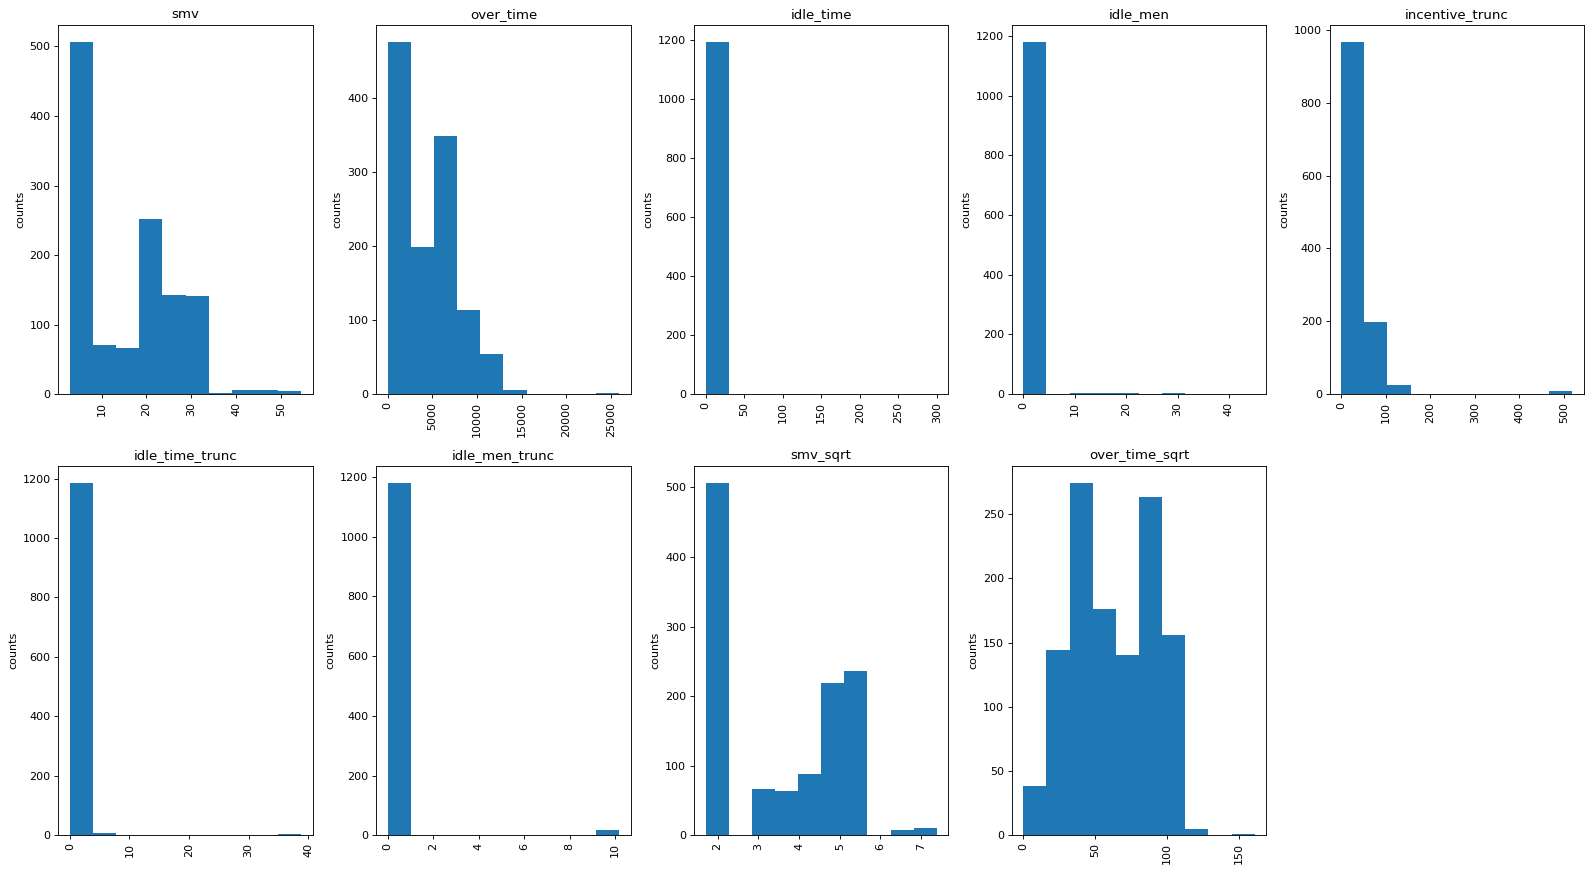

In [16]:
def trunc_sd(df, col, sd_number:int = 3):
    mean = df[col].mean()
    sd = df[col].std()
    upper_limit = mean + sd_number*sd
    lower_limit = mean - sd_number*sd
    return np.where(df[col] > upper_limit, upper_limit, np.where(df[col] < lower_limit, lower_limit, df[col]))

df_new = df_all[['smv', 'over_time', 'idle_time', 'idle_men']]

df_new['incentive_trunc'] = trunc_sd(df_all, 'incentive', 3)
df_new['idle_time_trunc'] = trunc_sd(df_all, 'idle_time', 3)
df_new['idle_men_trunc'] = trunc_sd(df_all, 'idle_men', 3)

df_new['smv_sqrt'] = np.sqrt(df_new['smv'])
df_new['over_time_sqrt'] = np.sqrt(df_new['over_time'])

plotColumnCounts(df_new, df_new.columns, 5)

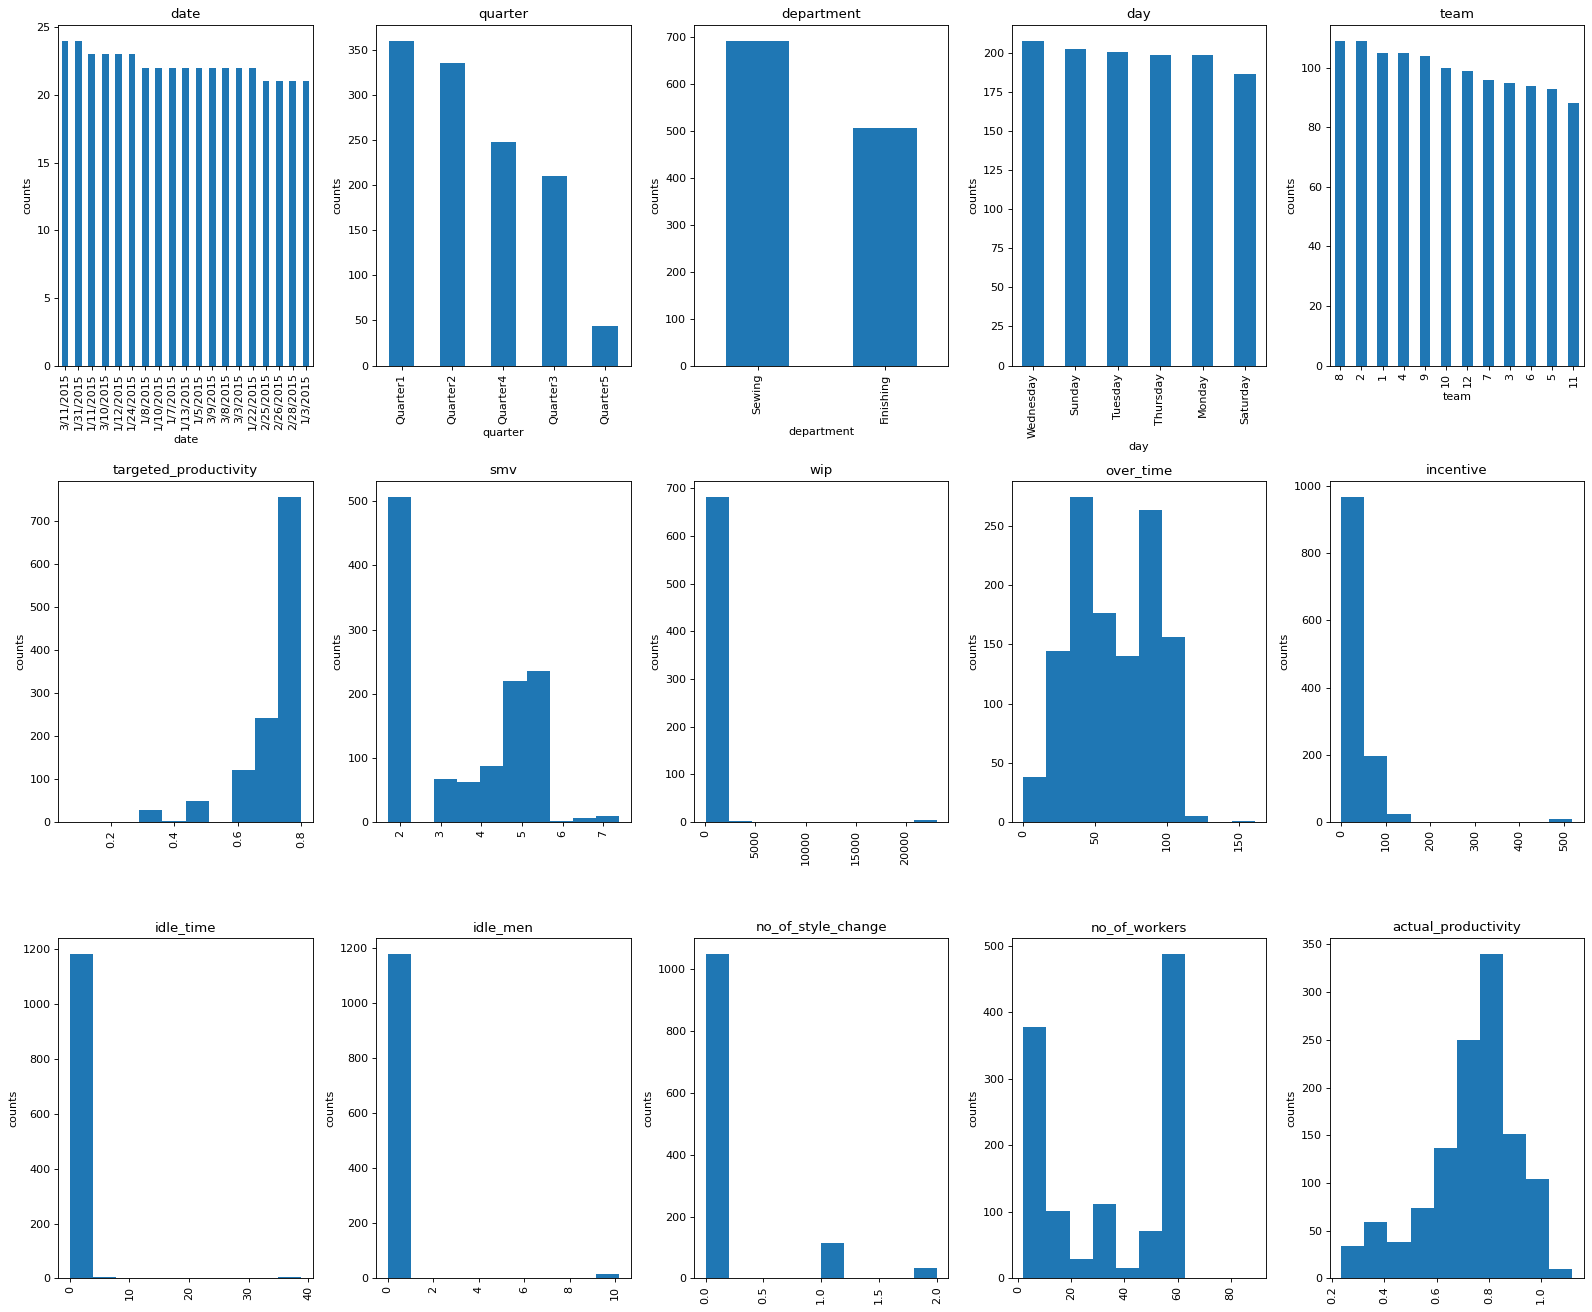

In [17]:
# copy the above transformations into df_all, overwriting previous columns
df_all['incentive'] = trunc_sd(df_all, 'incentive', 3)
df_all['idle_time'] = trunc_sd(df_all, 'idle_time', 3)
df_all['idle_men'] = trunc_sd(df_all, 'idle_men', 3)

df_all['smv'] = np.sqrt(df_all['smv'])
df_all['over_time'] = np.sqrt(df_all['over_time'])

plotColumnCounts(df_all, df_all.columns, 5)

## Dichotomize `actual_productivity`

In [18]:
df_all.actual_productivity.quantile(.75)

0.850252525

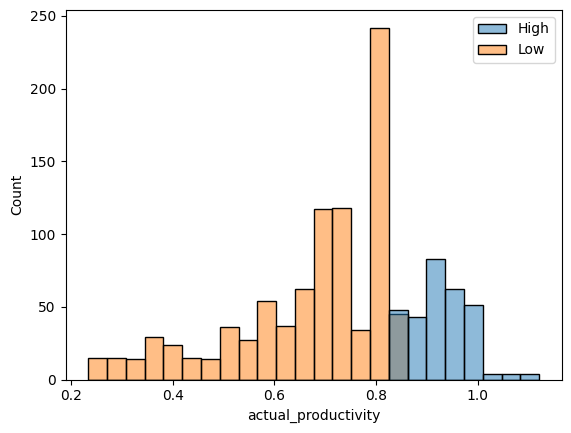

In [19]:
test = np.where(df_all.actual_productivity > df_all.actual_productivity.quantile(.75), 'High', 'Low')
sns.histplot(df_all, x = 'actual_productivity', hue = test) ; plt.show()

In [20]:
df_all['actual_productivity'] = np.where(df_all.actual_productivity > df_all.actual_productivity.quantile(.75), 'High', 'Low')
df_all.actual_productivity.value_counts()

actual_productivity
Low     898
High    299
Name: count, dtype: int64

# Create knn pipeline & perform gridsearch

In [21]:
X = df_all.drop(['wip', 'date', 'day', 'actual_productivity'], axis=1)
X['team'] = X['team'].astype('object')
#y = df_all.actual_productivity

y_encoder = LabelEncoder()
y = pd.DataFrame(1-y_encoder.fit_transform(df_all['actual_productivity']), columns=['actual_productivity'])['actual_productivity']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
print(X_train.info())
print(y_train.info())
pd.DataFrame({'a_p': df_all.actual_productivity, 'encoded': y}).value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 897 entries, 1183 to 1126
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                897 non-null    object 
 1   department             897 non-null    object 
 2   team                   897 non-null    object 
 3   targeted_productivity  897 non-null    float64
 4   smv                    897 non-null    float64
 5   over_time              897 non-null    float64
 6   incentive              897 non-null    float64
 7   idle_time              897 non-null    float64
 8   idle_men               897 non-null    float64
 9   no_of_style_change     897 non-null    int64  
 10  no_of_workers          897 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 84.1+ KB
None
<class 'pandas.core.series.Series'>
Index: 897 entries, 1183 to 1126
Series name: actual_productivity
Non-Null Count  Dtype
--------------  -----
897 no

a_p   encoded
Low   0          898
High  1          299
Name: count, dtype: int64

In [22]:
transformer = make_column_transformer(
    (OrdinalEncoder(categories=[quarter_levels]), ['quarter']),
    (OneHotEncoder(drop='if_binary'), ['department']),
    (TargetEncoder(), ['team']),
    remainder = StandardScaler()
)

knn_pipe = Pipeline([
    ('transformer', transformer),
    ('knn', KNeighborsClassifier())
])
knn_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Quarter1',
                                                                              'Quarter2',
                                                                              'Quarter3',
                                                                              'Quarter4',
                                                                              'Quarter5']]),
                                                  ['quarter']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['department']),
                                                 ('targetencoder',
                                                  TargetEncoder(),
                                                  ['team'])])),
                ('knn', KNeighborsClassifier())])

In [23]:
param_grid = {'knn__n_neighbors': range(1, len(y_test), 2)}

knn_grid = GridSearchCV(knn_pipe, param_grid = param_grid, scoring = 'average_precision')
knn_grid.fit(X_train, y_train)

9

In [31]:
best_k = knn_grid.best_params_['knn__n_neighbors']
print(best_k)
knn_grid.score(X_test, y_test)

9


0.644628322806891

In [24]:
# error metrics
predictions = knn_grid.best_estimator_.predict(X_test)

mis_rate = pd.DataFrame({'prediction': predictions, 'actual': y_test, 'hit': predictions == y_test})
print(mis_rate.value_counts())
print(f'Hit proportion: {(predictions==y_test).sum()/len(y_test)}')

prediction  actual  hit  
0           0       True     205
            1       False     37
1           1       True      37
            0       False     21
Name: count, dtype: int64
Hit proportion: 0.8066666666666666


## Visualizations
### Confusion Matrix

In [25]:
# prep
def precision_thresh(predict_probs, y_test, thresh):
    """Given predicted probabilities and a threshold, this function
    computes predictions for the positive class at or above the threshold
    and returns the subesequent precision score for that thresholds predictions 
    against the test data.
    
    Parameters
    ----------
    predict_probs: type 'np.ndarray'
        1D NumPy array of probabilities for positive class
    y_test: type `np.ndarray`
        1D NumPy array of test label
    thresh: type `float`
        threshold for positive classification at or above
          
    Returns a float for precision value
    """
    preds = np.where(predict_probs >= thresh, 'Yes', 'No')
    
    return precision_score(y_test, preds, pos_label='Yes')

best_pipe = Pipeline([
    ('transformer', transformer),
    ('knn', KNeighborsClassifier(n_neighbors = 9))
])
best_pipe.fit(X_train, y_train)

best_preds = best_pipe.predict(X_test)

mis_rate = pd.DataFrame({'prediction': best_preds, 'actual': y_test, 'hit': predictions == y_test})
print(mis_rate.value_counts())
print(f'Hit proportion: {(predictions==y_test).sum()/len(y_test)}')

prediction  actual  hit  
0           0       True     205
            1       False     37
1           1       True      37
            0       False     21
Name: count, dtype: int64
Hit proportion: 0.8066666666666666


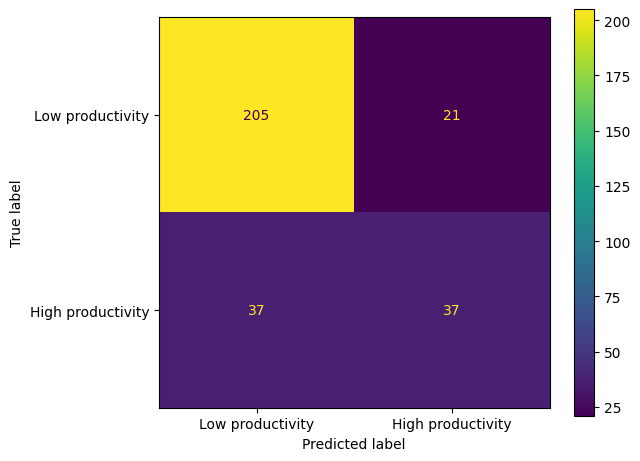

In [26]:
prod_confusion_mat = confusion_matrix(y_test, best_preds, labels=[0, 1]) # high productivity is 1
disp = ConfusionMatrixDisplay(confusion_matrix=prod_confusion_mat, display_labels=['Low productivity', 'High productivity'])
disp.plot()
plt.tight_layout()

### Curves

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
[0.24666667 0.42236025 0.48507463 0.53153153 0.56790123 0.63793103
 0.6875     0.77777778 1.         1.         1.        ]
[1.         0.91891892 0.87837838 0.7972973  0.62162162 0.5
 0.44594595 0.28378378 0.17567568 0.13513514 0.        ]


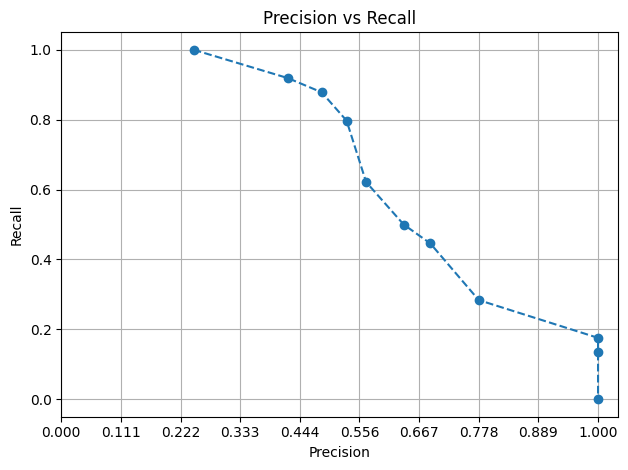

In [35]:
# precision-recall
best_probs = best_pipe.predict_proba(X_test)
y_test_obj = np.where(y_test == 0, 'Low', 'High')

precision, recall, boundaries = precision_recall_curve(y_test_obj, best_probs[:, 1], pos_label='High')

print(boundaries)
print(precision)
print(recall)
plt.plot(precision, recall, '--o')
plt.xticks(boundaries);
plt.grid()
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.title('Precision vs Recall')
plt.tight_layout()

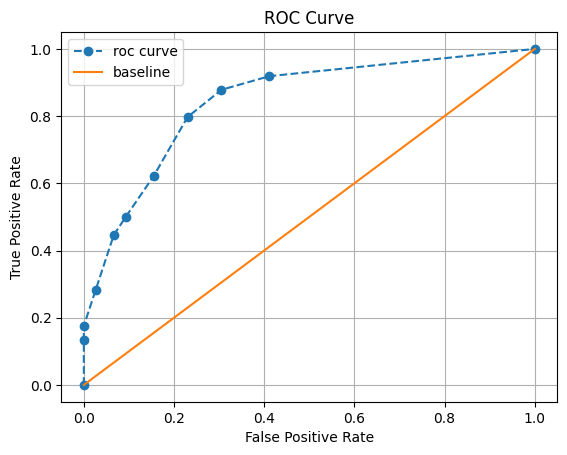

In [28]:
# roc curve
fpr, tpr, thresh_rocs = roc_curve(y_test_obj, best_probs[:, 1], pos_label='High')

plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()

In [79]:
# recall-precision curve

best_preds

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0])